### SWT-MRA(1D)를 input으로 넣고 1D를 output으로 출력하는 모델 -> MRA level을 feature로 봄
#### Contaminated, Clean Scale을 다르게 함. (각자 scaling)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pywt

import sys
sys.path.append('../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot_paper, Loss_Plot

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Contaminated_data.shape: (2000, 4000)
Clean_data.shape: (2000, 4000)


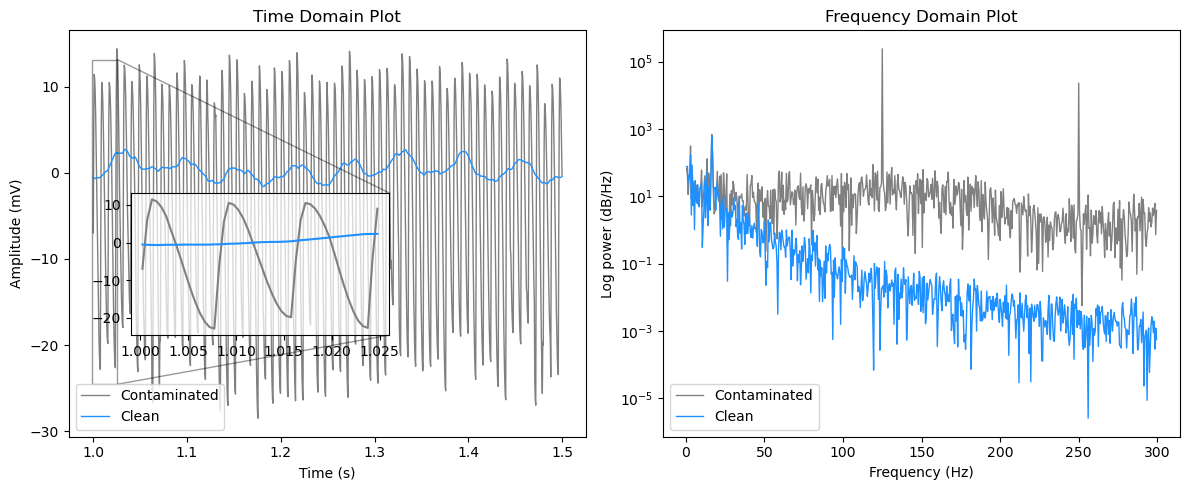

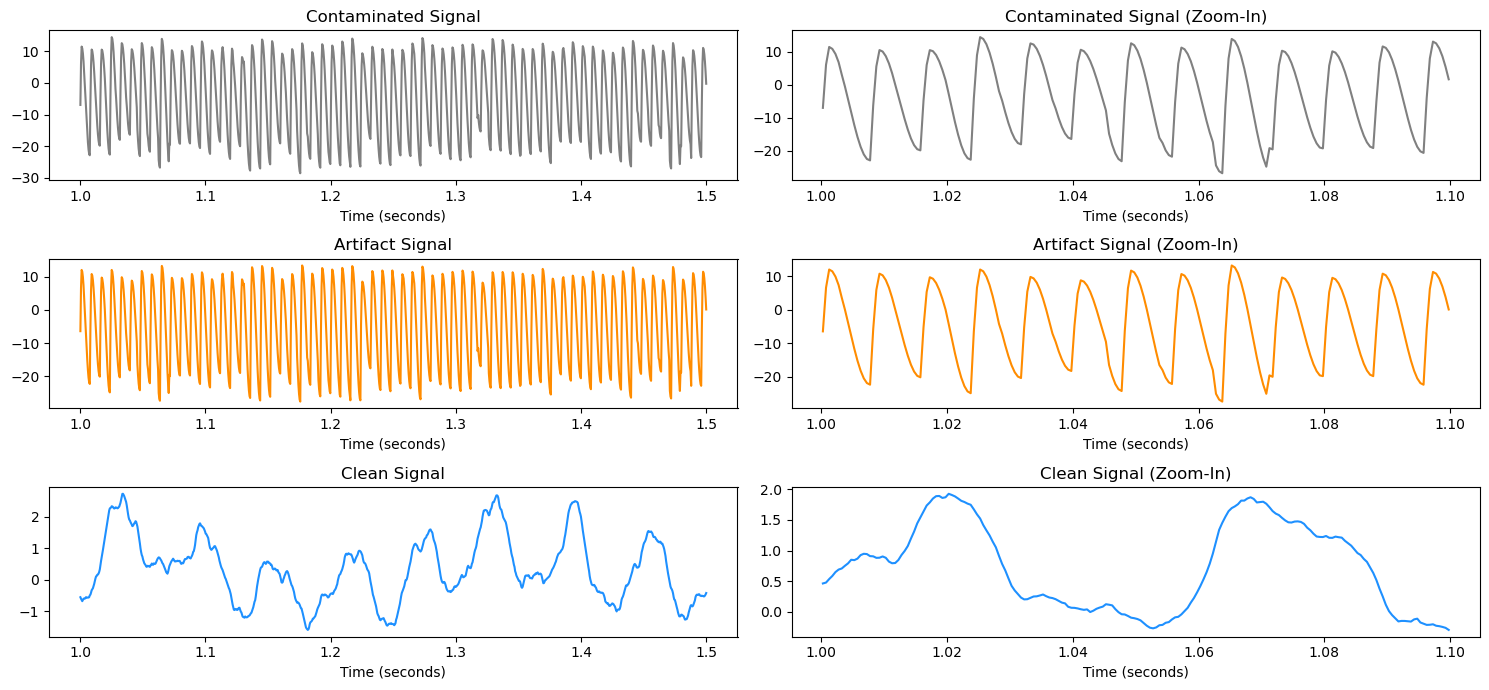

In [2]:
# 데이터 load & plot
datapath = "../data/synthetic_data/evaluation_data/"

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

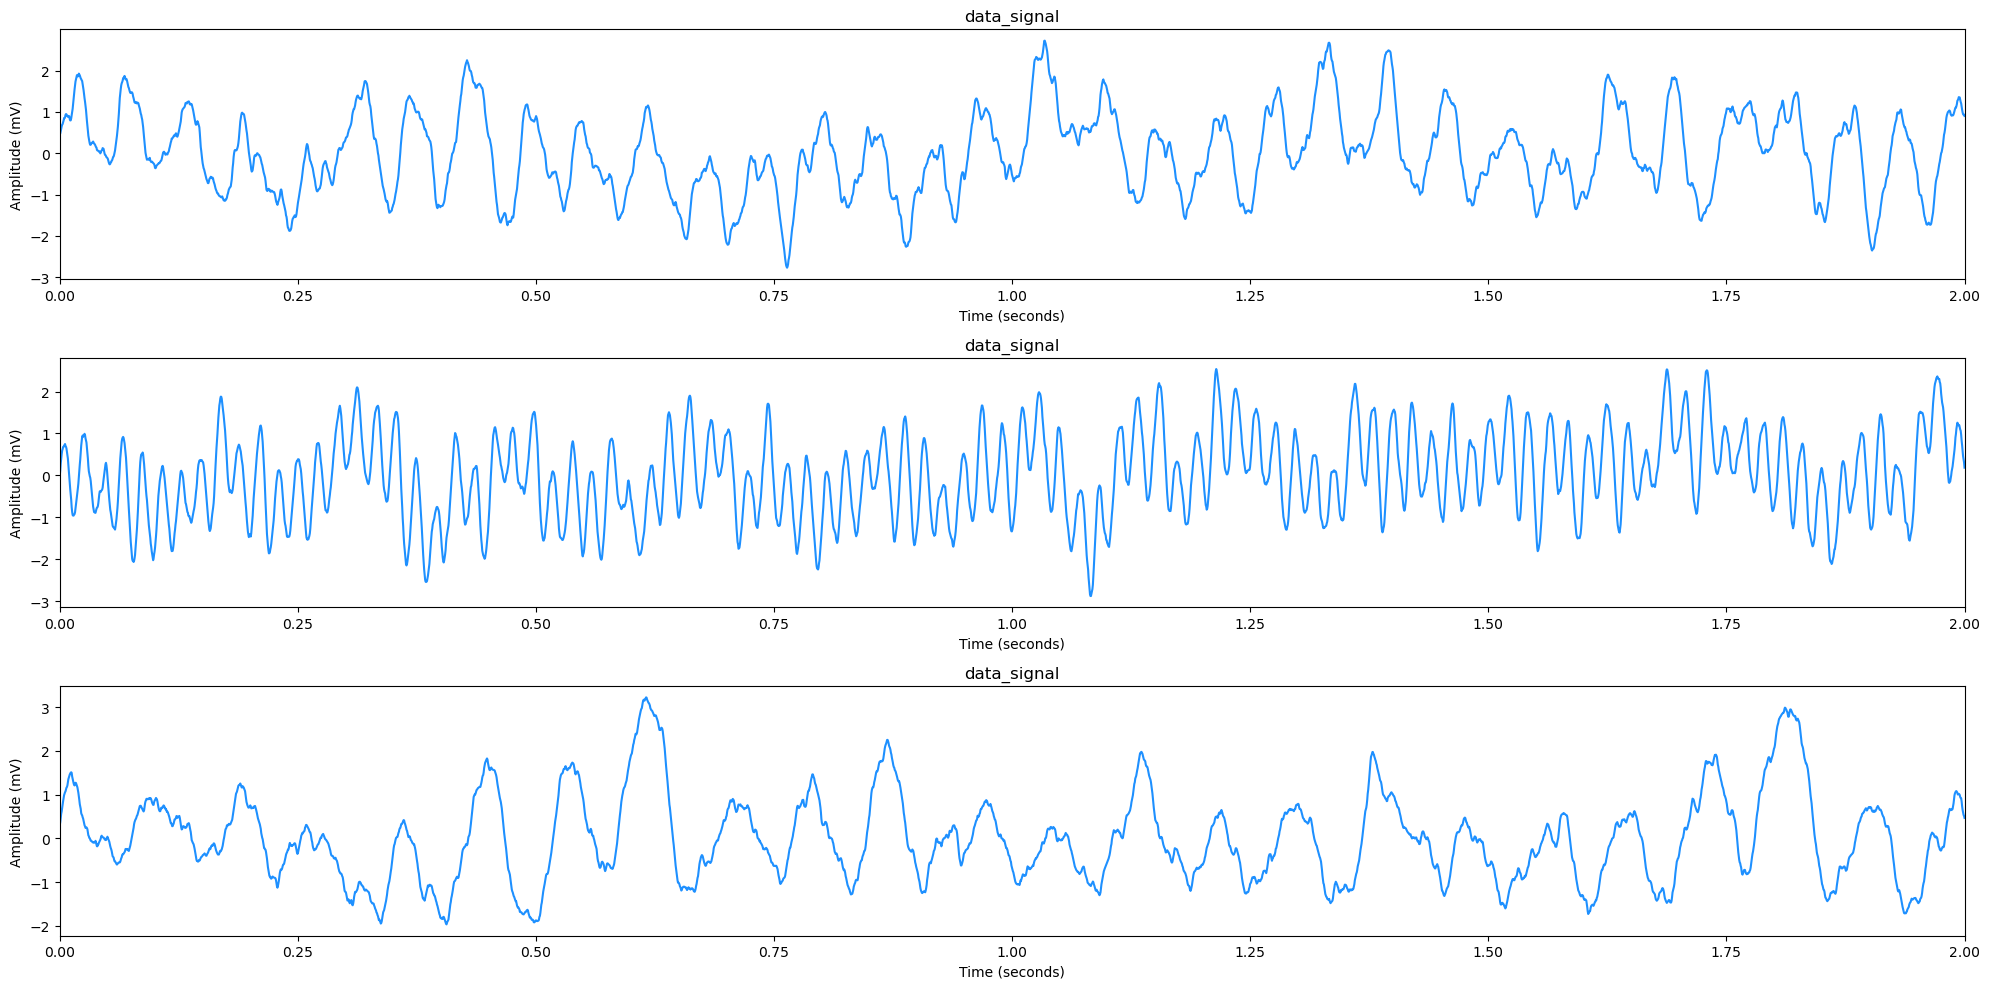

In [3]:
# 샘플 간 차이 확인
times = np.linspace(0, 2, 4000)

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.plot(times, Clean_data[0, :], label = 'data signal', c='dodgerblue')
plt.ylabel("Amplitude (mV)"); plt.xlabel("Time (seconds)");plt.title('data_signal')
plt.xlim([0, 2])

plt.subplot(3, 1, 2)
plt.plot(times, Clean_data[77, :], label = 'data signal', c='dodgerblue')
plt.ylabel("Amplitude (mV)"); plt.xlabel("Time (seconds)");plt.title('data_signal')
plt.xlim([0, 2])

plt.subplot(3, 1, 3)
plt.plot(times, Clean_data[165, :], label = 'data signal', c='dodgerblue')
plt.ylabel("Amplitude (mV)"); plt.xlabel("Time (seconds)");plt.title('data_signal')
plt.xlim([0, 2])

plt.tight_layout()

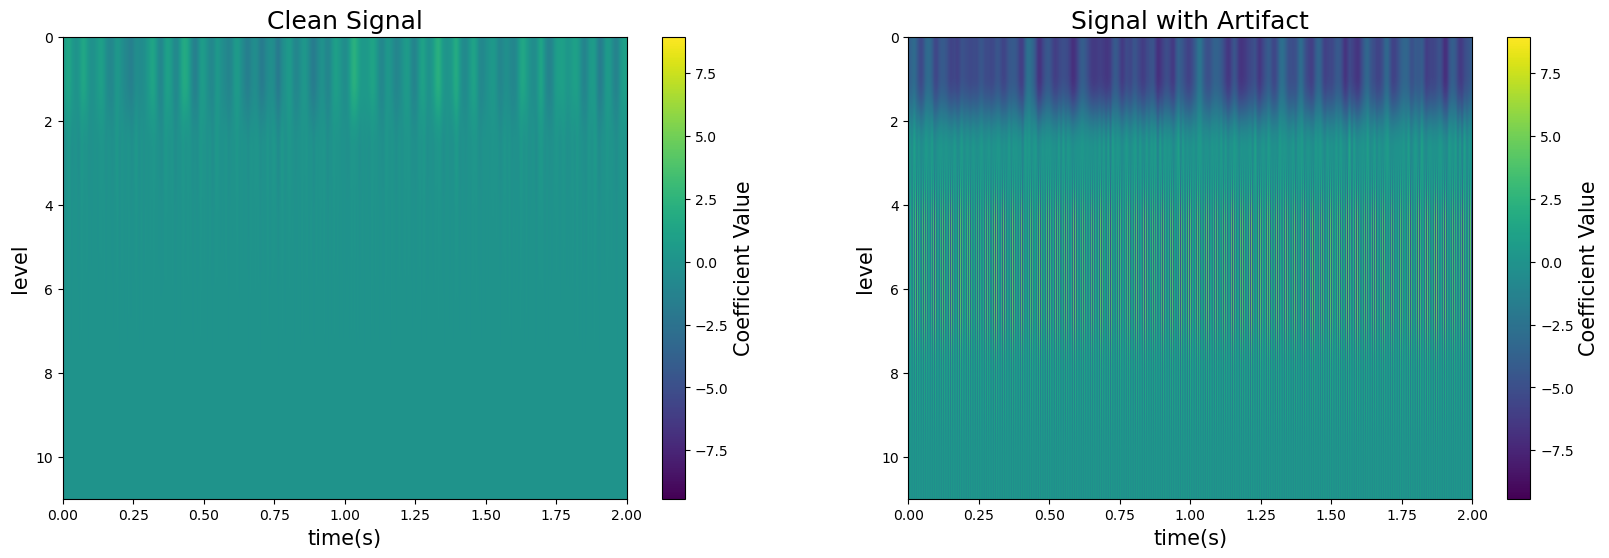

In [4]:
# SWT 수행 (MRA)
wavelet = 'db1'
mra_sig = pywt.mra(Clean_data[0], wavelet, transform='swt')
mra_art = pywt.mra(Contaminated_data[0], wavelet, transform='swt')

mra_sig = np.array(mra_sig)
mra_art = np.array(mra_art)

vmin, vmax = min(mra_sig.min(), mra_art.min()), max(mra_sig.max(), mra_art.max())

t = np.linspace(0, 2, num=4000)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.imshow(mra_sig, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean Signal', fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(mra_art, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Signal with Artifact', fontsize=18)

plt.show()

In [5]:
X_wt = []
y_wt = []

wavelet = 'db1'

for x, y in zip(Contaminated_data[200:400], Clean_data[200:400]):
    mra_x = pywt.mra(x, wavelet, transform='swt')
    mra_y = pywt.mra(y, wavelet, transform='swt')
    X_wt.append(mra_x)
    y_wt.append(mra_y)

X_wt = np.array(X_wt)
y_wt = np.array(y_wt)

print("X_wt:", X_wt.shape)
print("y_wt:", y_wt.shape)

X_wt: (200, 6, 4000)
y_wt: (200, 6, 4000)


In [6]:
# MRA 결과 scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = []
y = [] 

scaler_x.fit(X_wt[0].flatten().reshape(-1, 1))
scaler_y.fit(y_wt[0].flatten().reshape(-1, 1))

for xx, yy in zip(X_wt, y_wt):
    flat_x = xx.flatten().reshape(-1, 1)
    flat_y = yy.flatten().reshape(-1, 1)
    scaled_flat_x = scaler_x.transform(flat_x)
    scaled_flat_y = scaler_y.transform(flat_y) # X, y 각자 scaling
    X.append(scaled_flat_x.reshape(xx.shape))
    y.append(scaled_flat_y.reshape(yy.shape))

X = np.array(X)
y = np.array(y)

print("X:", X.shape)
print("y:", y.shape)

X: (200, 6, 4000)
y: (200, 6, 4000)


In [7]:
# Data preprocessing
print("<Data Shape>")
print("-----------------------------")
print(f"X_test shape: {X.shape}\ny_test shape: {y.shape}")
print("-----------------------------")

eval_test_dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
eval_test_loader = DataLoader(dataset=eval_test_dataset, batch_size=32, shuffle=False)

<Data Shape>
-----------------------------
X_test shape: (200, 6, 4000)
y_test shape: (200, 6, 4000)
-----------------------------


In [8]:
class CNN_MRA_1D(nn.Module):
    def __init__(self, in_channels=12, out_channels=12):
        super(CNN_MRA_1D, self).__init__()
        
        # Encoding path
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool1d(2, 2)
        
        # Decoding path
        self.upconv4 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = nn.Conv1d(64, out_channels, kernel_size=1)

        self.gelu = nn.GELU()
        
    def forward(self, x):
        # Encoding
        x1 = self.gelu(self.conv1(x))
        x2 = self.pool(self.gelu(self.conv2(x1)))
        x3 = self.pool(self.gelu(self.conv3(x2)))
        x4 = self.pool(self.gelu(self.conv4(x3)))

        # Decoding
        x4_up = self.upconv4(x4)
        x3_up = self.upconv3(x4_up)
        x2_up = self.upconv2(x3_up)
        x_out = self.upconv1(x2_up)
        
        return x_out

In [9]:
eval_model = CNN_MRA_1D(in_channels=6, out_channels=6).to(device)
eval_model.load_state_dict(torch.load('../saved_data/saved_model/CNN_IO_MRA_1D_swt_10000.pth'))

criterion = nn.MSELoss()

print(eval_model)

CNN_MRA_1D(
  (conv1): Conv1d(6, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upconv4): ConvTranspose1d(512, 256, kernel_size=(2,), stride=(2,))
  (upconv3): ConvTranspose1d(256, 128, kernel_size=(2,), stride=(2,))
  (upconv2): ConvTranspose1d(128, 64, kernel_size=(2,), stride=(2,))
  (upconv1): Conv1d(64, 6, kernel_size=(1,), stride=(1,))
  (gelu): GELU(approximate='none')
)


C:\Users\stell\AppData\Local\Temp\ipykernel_10816\804877557.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_model.load_state_dict(torch.load('../saved_data/saved_mo

In [10]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

eval_model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in eval_test_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred = eval_model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

test_loss /= len(eval_test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0723


Mean Absolute Error: 0.15172864496707916
Mean Squared Error: 0.06338074058294296


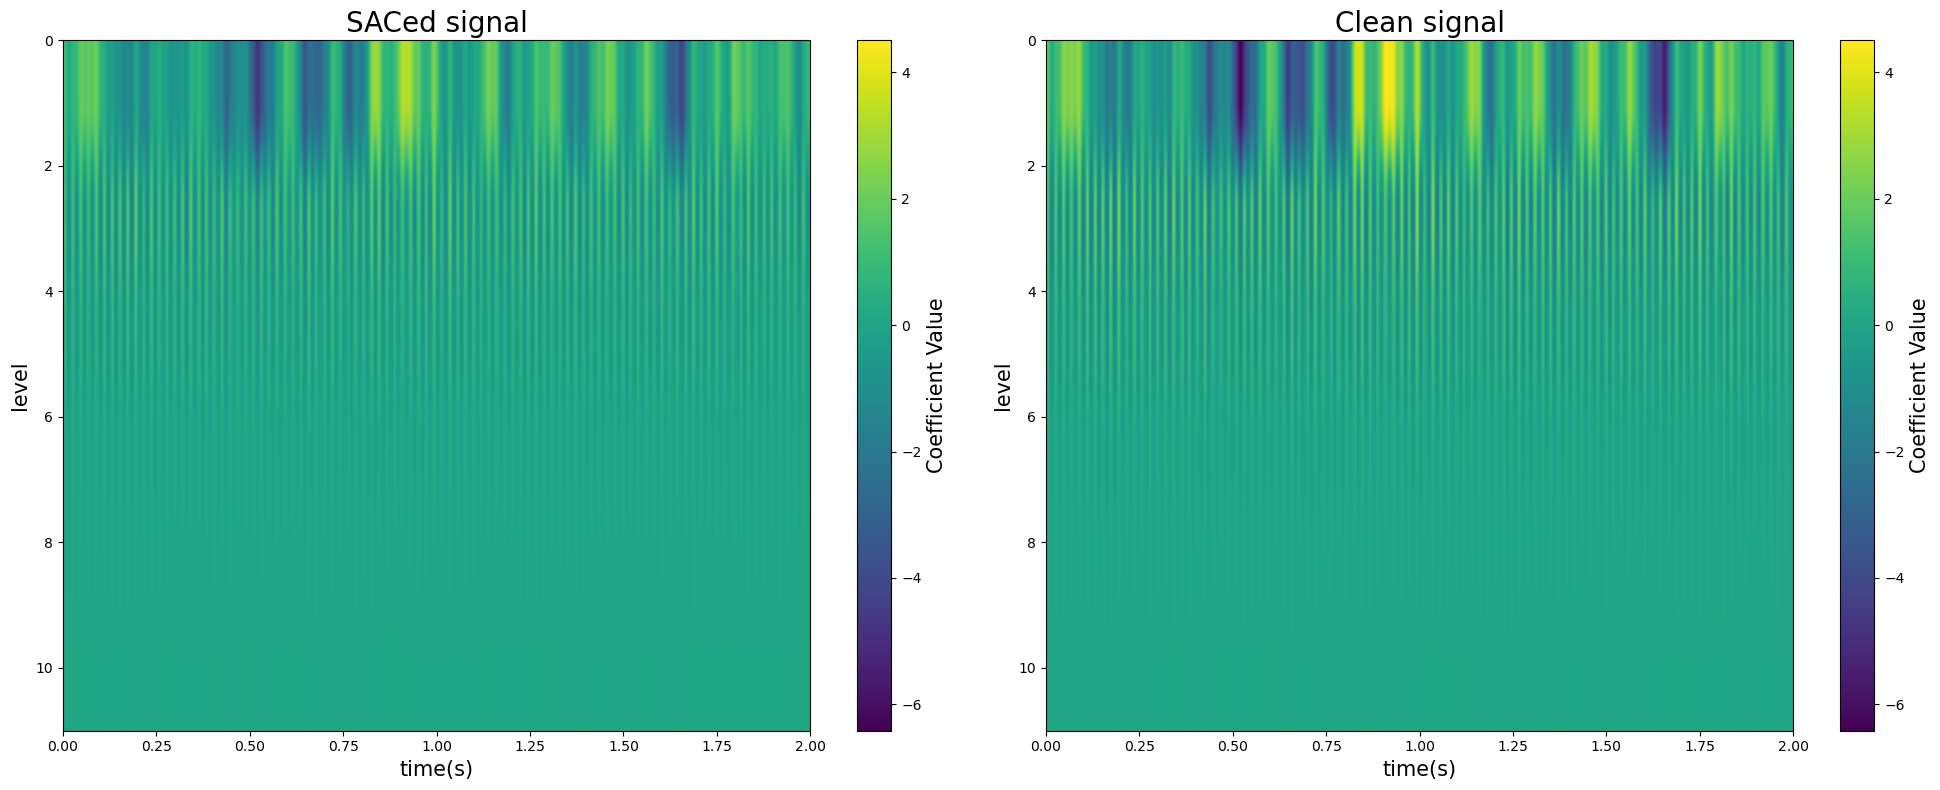

In [11]:
# MRA Plot
SACed_ex = SACed[0].detach().cpu()
Clean_ex = Clean[0].detach().cpu()

vmin, vmax = min(SACed_ex.min(), Clean_ex.min()), max(SACed_ex.max(), Clean_ex.max())

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(SACed_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('SACed signal', fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(Clean_ex, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax, extent=[t[0], t[-1], 11, 0])
plt.colorbar().set_label('Coefficient Value', fontsize=15)
plt.xlabel('time(s)', fontsize=15)
plt.ylabel('level', fontsize=15)
plt.title('Clean signal', fontsize=20)

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_ex, SACed_ex)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_ex, SACed_ex)}")

In [12]:
# MRA 결과 inverse scaling
Contaminated_inverse_scaled = []
SACed_inverse_scaled = []
Clean_inverse_scaled = []

for xx, yhat, yy in zip(Contaminated, SACed, Clean):
    flat_x = xx.flatten().reshape(-1, 1)
    flat_yhat = yhat.flatten().reshape(-1, 1)
    flat_y = yy.flatten().reshape(-1, 1)

    inv_flat_x = scaler_x.inverse_transform(flat_x)
    inv_flat_yhat = scaler_y.inverse_transform(flat_yhat)
    inv_flat_y = scaler_y.inverse_transform(flat_y)

    Contaminated_inverse_scaled.append(inv_flat_x.reshape(xx.shape))
    SACed_inverse_scaled.append(inv_flat_yhat.reshape(yhat.shape))
    Clean_inverse_scaled.append(inv_flat_y.reshape(yy.shape))

Contaminated_inverse_scaled = np.array(Contaminated_inverse_scaled)
SACed_inverse_scaled = np.array(SACed_inverse_scaled)
Clean_inverse_scaled = np.array(Clean_inverse_scaled)


# MRA 데이터를 inverse하여 시계열 데이터로 변환

Contaminated_invdwt = []
SACed_invdwt = []
Clean_invdwt = []

for mra_x, mra_yhat, mra_y in zip(Contaminated_inverse_scaled, SACed_inverse_scaled, Clean_inverse_scaled):
    contaminated_invdwt = pywt.imra(mra_x)
    saced_invdwt = pywt.imra(mra_yhat)
    clean_invdwt = pywt.imra(mra_y)
    
    Contaminated_invdwt.append(contaminated_invdwt)
    SACed_invdwt.append(saced_invdwt)
    Clean_invdwt.append(clean_invdwt)

Contaminated_invdwt = np.array(Contaminated_invdwt)
SACed_invdwt = np.array(SACed_invdwt)
Clean_invdwt = np.array(Clean_invdwt)

print("X_reconstructed:", Contaminated_invdwt.shape)
print("yhat_reconstructed:", SACed_invdwt.shape)
print("y_reconstructed:", Clean_invdwt.shape)

X_reconstructed: (200, 4000)
yhat_reconstructed: (200, 4000)
y_reconstructed: (200, 4000)


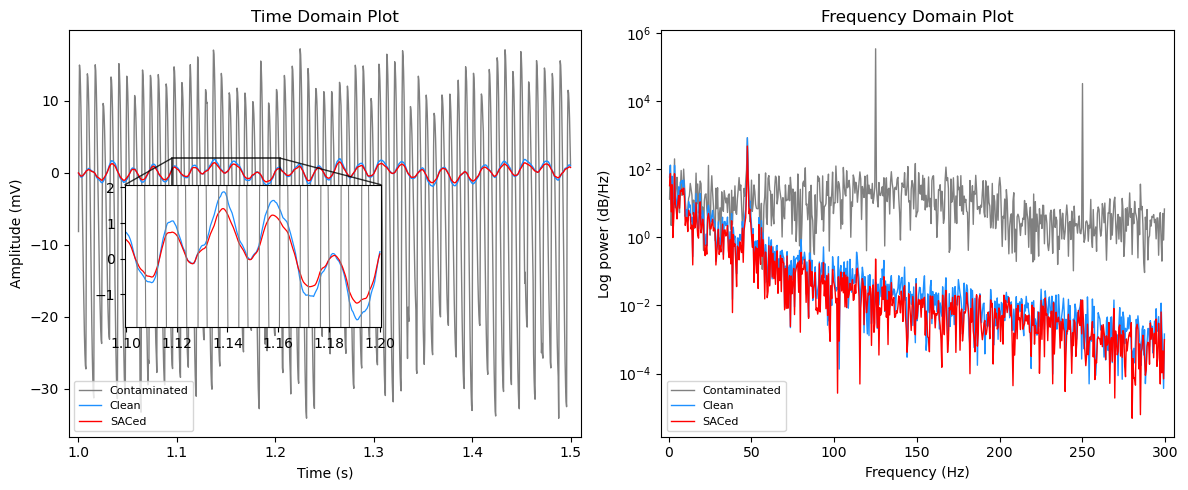

< MSE >
Time Domain MSE: 0.06302940720826797 ± 0.001024581554435019
Frequency Domain MSE: 271.0658994490504 ± 112.18691227259802
Time + Frequency MSE: 11.197260031037004 ± 1.7598186578875734


In [13]:
# 결과 Plot

save_path = '../result/evaluation/'
save_title = 'eval_CNN_IO_MRA_1D_swt_10000'

Result_Plot(Contaminated_invdwt, SACed_invdwt, Clean_invdwt) # inverse scaled data를 input으로 넣음
# Result_Plot_paper(Contaminated_invdwt, SACed_invdwt, Clean_invdwt, save_path, save_title) # inverse scaled data를 input으로 넣음